In [1]:
import sys
from pathlib import Path
from functools import partial
from pprint import pprint
import random
sys.path.append(Path.cwd().parent.__str__())
from dronescapes_reader import MultiTaskDataset, DepthRepresentation, OpticalFlowRepresentation, SemanticRepresentation
from torch.utils.data import DataLoader
import numpy as np
import torch as tr
from media_processing_lib.collage_maker import collage_fn
from media_processing_lib.image import image_add_title
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
sema_repr = partial(SemanticRepresentation, classes=8, color_map=[[0, 255, 0], [0, 127, 0], [255, 255, 0],
                                                                  [255, 255, 255], [255, 0, 0], [0, 0, 255],
                                                                  [0, 255, 255], [127, 127, 63]])
reader = MultiTaskDataset("../data/train_set", handle_missing_data="fill_none",
                          task_types={"depth_dpt": DepthRepresentation("depth_dpt", min_depth=0, max_depth=0.999),
                                      "depth_sfm_manual202204": DepthRepresentation("depth_sfm_manual202204",
                                                                                    min_depth=0, max_depth=300),
                                      "opticalflow_rife": OpticalFlowRepresentation,
                                      "semantic_segprop8": sema_repr,
                                      "semantic_mask2former_swin_mapillary_converted": sema_repr})
print(reader)
print("== Shapes ==")
pprint(reader.data_shape)

[24-05-13 15:03:00 DEBUG] Building dataset from: '/scratch/sdc/datasets/dronescapes/scripts/../data/train_set' (multitask_dataset.py:186)
[24-05-13 15:03:01 INFO] Found 11664 data points as union of all nodes' data (8 nodes). (multitask_dataset.py:174)
[24-05-13 15:03:01 DEBUG] No explicit tasks provided. Using all of them as read from the paths (8). (multitask_dataset.py:86)
[24-05-13 15:03:01 INFO] Tasks used in this dataset: ['depth_dpt', 'depth_sfm_manual202204', 'edges_dexined', 'normals_sfm_manual202204', 'opticalflow_rife', 'rgb', 'semantic_mask2former_swin_mapillary_converted', 'semantic_segprop8'] (multitask_dataset.py:93)


[MultiTaskDataset]
 - Path: '/scratch/sdc/datasets/dronescapes/scripts/../data/train_set'
 - Only full data: False
 - Representations (8): [DepthRepresentation(depth_dpt), DepthRepresentation(depth_sfm_manual202204), NpzRepresentation(edges_dexined), NpzRepresentation(normals_sfm_manual202204), OpticalFlowRepresentation(opticalflow_rife), NpzRepresentation(rgb), SemanticRepresentation(semantic_mask2former_swin_mapillary_converted), SemanticRepresentation(semantic_segprop8)]
 - Length: 11664
== Shapes ==
{'depth_dpt': torch.Size([540, 960]),
 'depth_sfm_manual202204': torch.Size([540, 960]),
 'edges_dexined': torch.Size([540, 960]),
 'normals_sfm_manual202204': torch.Size([540, 960, 3]),
 'opticalflow_rife': torch.Size([540, 960, 2]),
 'rgb': torch.Size([540, 960, 3]),
 'semantic_mask2former_swin_mapillary_converted': torch.Size([540, 960]),
 'semantic_segprop8': torch.Size([540, 960])}


== Random loaded item ==
{'depth_dpt': (540, 960, 3),
 'depth_sfm_manual202204': (540, 960, 3),
 'edges_dexined': (540, 960, 3),
 'normals_sfm_manual202204': (540, 960, 3),
 'opticalflow_rife': (540, 960, 3),
 'rgb': (540, 960, 3),
 'semantic_mask2former_swin_mapillary_converted': (540, 960, 3),
 'semantic_segprop8': (540, 960, 3)}


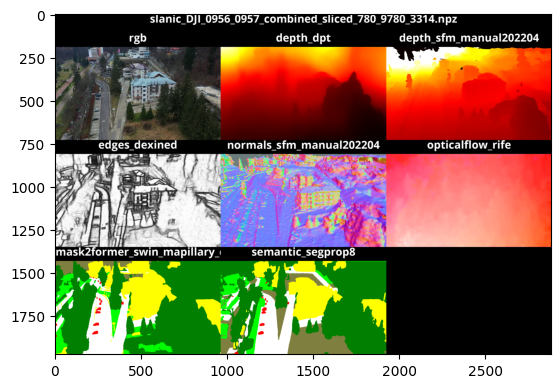

In [5]:
print("== Random loaded item ==")
rand_ix = random.randint(0, len(reader))
data, name, repr_names = reader[rand_ix] # get a random item
img_data = {}
for k, v in data.items():
    img_data[k] = reader.name_to_task[k].plot_fn(v) if v is not None else np.zeros((*reader.data_shape[k][0:2], 3))
if "rgb" in img_data: # move rgb as 1st item in the collage
    img_data = {"rgb": img_data["rgb"], **{k: v for k, v in img_data.items() if k != "rgb"}}
pprint({k: v.shape for k, v in img_data.items()})
collage = collage_fn(list(img_data.values()), titles=img_data.keys(), size_px=55)
collage = image_add_title(collage, name, size_px=55, top_padding=110)
plt.imshow(collage)